In [1]:
!pip install kenlm
!pip install datasets

In [2]:
import os
import subprocess
import tempfile
import requests
from datasets import load_dataset
import kenlm
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import re

In [3]:
# Install required packages
def install_requirements():
    """Install required packages"""
    packages = [
        "datasets",
        "kenlm",
        "matplotlib",
        "numpy",
        "requests"
    ]

    for package in packages:
        try:
            __import__(package)
        except ImportError:
            print(f"Installing {package}...")
            subprocess.check_call(["pip", "install", package])


In [ ]:
def load_small_dataset(dataset_name, config_name, split_name, max_examples=10):

    print(f"Loading {max_examples} examples from {dataset_name}...")

    try:
        # Method 1: Use split slice notation (most efficient)
        split_slice = f"{split_name}[:{max_examples}]"
        dataset = load_dataset(dataset_name, config_name, split=split_slice)
        print(f"✓ Loaded {len(dataset)} examples using split slice")
        return dataset

    except Exception as e1:
        print(f"Split slice failed: {e1}")

        try:
            # Method 2: Use percentage (good for very large datasets)
            if max_examples <= 10:
                percentage = "0.01%"  # ~1000 examples for most datasets
            elif max_examples <= 5000:
                percentage = "0.05%"
            else:
                percentage = "0.1%"

            split_percent = f"{split_name}[:{percentage}]"
            dataset = load_dataset(dataset_name, config_name, split=split_percent)
            print(f"✓ Loaded {len(dataset)} examples using percentage")
            return dataset

        except Exception as e2:
            print(f"Percentage method failed: {e2}")

            try:
                # Method 3: Load full dataset and select subset (last resort)
                print("Loading full dataset and selecting subset...")
                print("⚠️  This may take longer and use more memory")

                dataset = load_dataset(dataset_name, config_name, split=split_name)
                dataset = dataset.select(range(min(max_examples, len(dataset))))
                print(f"✓ Loaded {len(dataset)} examples using select method")
                return dataset

            except Exception as e3:
                print(f"All methods failed: {e3}")
                raise Exception("Could not load dataset with any method")


In [ ]:
def safe_dataset_load():

    print("=== Safe Dataset Loading for Google Colab ===\n")

    # Example usage for different datasets
    datasets_to_try = [
        ("c4", "realnewslike", "train", 10),
        ("c4", "en", "train", 10),
    ]

    loaded_datasets = {}

    for dataset_name, config, split, max_ex in datasets_to_try:
        try:
            print(f"\nTrying to load {dataset_name} ({config})...")
            dataset = load_small_dataset(dataset_name, config, split, max_ex)
            loaded_datasets[f"{dataset_name}_{config}"] = dataset

            # Show sample
            print(f"Sample text: {dataset[0]['text'][:100]}...")

        except Exception as e:
            print(f"Failed to load {dataset_name} ({config}): {e}")
            continue

    return loaded_datasets

In [ ]:
def download_kenlm():
    if not os.path.exists("kenlm"):
        print("Downloading KenLM...")
        subprocess.run(["git", "clone", "https://github.com/kpu/kenlm.git"])

        print("Compiling KenLM...")
        os.chdir("kenlm")
        subprocess.run(["mkdir", "-p", "build"])
        os.chdir("build")
        subprocess.run(["cmake", ".."])
        subprocess.run(["make", "-j4"])
        os.chdir("../..")

# Sample texts for different styles
SAMPLE_TEXTS = {
    "social_media": [
        "omg just had the BEST coffee ever ☕️ #blessed #morningvibes can't even",
        "RT if u agree pizza is life 🍕🍕🍕 no cap fr fr",
        "this weather tho... why is it so hot?? 😭😭 need AC asap",
        "yasss queen! loving this energy 💅✨ periodt",
        "bruh why ppl gotta be so extra tho lmaooo 😂😂😂"
    ],

    "seo_spam": [
        "Buy cheap viagra online now! Best prices guaranteed! Click here for amazing deals!",
        "Make money fast from home! Earn $5000 per week! No experience needed! Sign up today!",
        "Weight loss miracle! Lose 50 pounds in 30 days! Doctors hate this one trick!",
        "Casino online best bonus free spins slot machine jackpot win money gambling",
        "SEO services cheap backlinks high quality traffic boost rankings guaranteed results"
    ],

    "slang_heavy": [
        "yo this track is straight fire ngl, the beat hits different fr",
        "that fit is lowkey bussin, where'd you cop those kicks tho?",
        "bro said he's the goat but he's mid at best, no cap",
        "she really thought she did something but it ain't it chief",
        "this party finna be lit, pull up if you tryna vibe"
    ],

    "formal_text": [
        "The implementation of sustainable energy solutions requires comprehensive policy frameworks.",
        "Research indicates that climate change mitigation strategies must incorporate technological innovations.",
        "Economic development policies should prioritize environmental sustainability and social equity.",
        "Educational institutions play a crucial role in fostering critical thinking skills.",
        "Healthcare systems require adequate funding to ensure universal access to medical services."
    ]
}

In [ ]:
def calculate_perplexity(model, text):
    # Clean text
    text = text.lower().strip()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation

    # Calculate log probability
    log_prob = model.score(text, bos=True, eos=True)

    # Count words
    words = text.split()
    word_count = len(words)

    if word_count == 0:
        return float('inf')

    # Calculate perplexity
    perplexity = 10 ** (-log_prob / word_count)
    return perplexity

def analyze_text_styles():
    print("=== Text Style Perplexity Analysis ===\n")

    # For this demo, we'll use a simple character-based approach
    # In practice, you'd use a proper language model

    results = {}

    for style, texts in SAMPLE_TEXTS.items():
        perplexities = []
        print(f"\n{style.upper().replace('_', ' ')} EXAMPLES:")
        print("-" * 40)

        for text in texts:
            # Simple character-based perplexity approximation
            # Real implementation would use proper tokenization
            char_freqs = defaultdict(int)
            for char in text.lower():
                if char.isalpha() or char.isspace():
                    char_freqs[char] += 1

            total_chars = sum(char_freqs.values())
            if total_chars == 0:
                perplexity = float('inf')
            else:
                # Calculate entropy-based perplexity approximation
                entropy = 0
                for count in char_freqs.values():
                    prob = count / total_chars
                    entropy -= prob * np.log2(prob)
                perplexity = 2 ** entropy

            perplexities.append(perplexity)
            print(f"Text: {text[:50]}...")
            print(f"Perplexity: {perplexity:.2f}\n")

        results[style] = {
            'perplexities': perplexities,
            'mean': np.mean(perplexities),
            'std': np.std(perplexities)
        }

    # Plot results
    styles = list(results.keys())
    means = [results[style]['mean'] for style in styles]
    stds = [results[style]['std'] for style in styles]

    plt.figure(figsize=(12, 6))
    bars = plt.bar(styles, means, yerr=stds, capsize=5, alpha=0.7)
    plt.title('Average Perplexity by Text Style')
    plt.ylabel('Perplexity')
    plt.xlabel('Text Style')
    plt.xticks(rotation=45)

    # Add value labels on bars
    for bar, mean in zip(bars, means):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{mean:.1f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig('perplexity_by_style.png', dpi=300, bbox_inches='tight')
    plt.show()

    return results

def train_kenlm_model():
    print("\n=== Training KenLM Model ===\n")

    try:
        # Load a small subset of C4 realnewslike data
        print("Loading C4 realnewslike dataset...")
        # Method 1: Load first N examples using split syntax
        dataset = load_dataset("c4", "realnewslike", split="train[:10]")

        # Alternative methods if above doesn't work:
        # Method 2: Load and select subset
        # dataset = load_dataset("c4", "realnewslike", split="train")
        # dataset = dataset.select(range(5000))

        # Method 3: Use percentage
        # dataset = load_dataset("c4", "realnewslike", split="train[:1%]")

        # Create training data file
        train_file = "train_data.txt"
        print(f"Creating training file: {train_file}")

        with open(train_file, 'w', encoding='utf-8') as f:
            count = 0
            # Now we can iterate normally since we loaded a subset
            for example in dataset:
                text = example['text'].strip()
                if len(text) > 50:  # Filter very short texts
                    # Clean text
                    text = re.sub(r'\s+', ' ', text)  # Normalize whitespace
                    f.write(text + '\n')
                    count += 1

                if count % 10 == 0:
                    print(f"Processed {count} documents...")

        print(f"Training data prepared with {count} documents")

        # Train KenLM model
        model_file = "model.arpa"
        print("Training KenLM model...")

        # Check if KenLM binaries exist
        lmplz_path = "./kenlm/build/bin/lmplz"
        if not os.path.exists(lmplz_path):
            print("KenLM not found. Using alternative approach...")
            return None

        # Train 3-gram model
        with open(model_file, 'w') as f:
            subprocess.run([
                lmplz_path,
                "-o", "3",  # 3-gram model
                "--discount_fallback"
            ], stdin=open(train_file, 'r'), stdout=f, check=True)

        print(f"Model trained and saved to {model_file}")

        # Load the trained model
        model = kenlm.Model(model_file)
        print("Model loaded successfully!")

        return model

    except Exception as e:
        print(f"Error training model: {e}")
        print("Using pre-trained model approach...")
        return None


In [ ]:
def evaluate_c4_documents(model=None):
    print("\n=== Evaluating C4 Documents ===\n")

    if model is None:
        print("No trained model available. Using simple evaluation...")

    try:
        # Load unclean C4 data for evaluation - small subset only
        print("Loading C4 dataset for evaluation...")
        # Load first 10 examples
        dataset = load_dataset("c4", "en", split="train[:10]")

        documents = []
        perplexities = []

        print("Evaluating documents...")
        for i, example in enumerate(dataset):
            text = example['text'].strip()
            if len(text) > 100:  # Filter very short texts
                documents.append(text[:200])  # Keep first 200 chars for display

                if model:
                    perplexity = calculate_perplexity(model, text)
                else:
                    # Simple fallback evaluation
                    word_count = len(text.split())
                    unique_words = len(set(text.split()))
                    perplexity = word_count / max(unique_words, 1) * 10  # Simple heuristic

                perplexities.append(perplexity)

            if i % 50 == 0:
                print(f"Processed {i} documents...")

        print(f"Evaluated {len(documents)} documents total")

        # Find highest and lowest perplexity documents
        perplexities = np.array(perplexities)

        highest_idx = np.argsort(perplexities)[-5:][::-1]  # Top 5 highest
        lowest_idx = np.argsort(perplexities)[:5]  # Top 5 lowest

        print("\n=== HIGHEST PERPLEXITY DOCUMENTS ===")
        print("(Likely lower quality)")
        for i, idx in enumerate(highest_idx):
            print(f"\n{i+1}. Perplexity: {perplexities[idx]:.2f}")
            print(f"Text: {documents[idx]}...")

        print("\n=== LOWEST PERPLEXITY DOCUMENTS ===")
        print("(Likely higher quality)")
        for i, idx in enumerate(lowest_idx):
            print(f"\n{i+1}. Perplexity: {perplexities[idx]:.2f}")
            print(f"Text: {documents[idx]}...")

        # Plot perplexity distribution
        plt.figure(figsize=(10, 6))
        plt.hist(perplexities, bins=30, alpha=0.7, edgecolor='black')
        plt.title('Distribution of Document Perplexities')
        plt.xlabel('Perplexity')
        plt.ylabel('Frequency')
        plt.axvline(np.mean(perplexities), color='red', linestyle='--',
                   label=f'Mean: {np.mean(perplexities):.2f}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.savefig('perplexity_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()

        return {
            'documents': documents,
            'perplexities': perplexities,
            'highest_idx': highest_idx,
            'lowest_idx': lowest_idx
        }

    except Exception as e:
        print(f"Error evaluating documents: {e}")
        return None

def analyze_perplexity_quality():
    print("\n=== Perplexity as Quality Measure Analysis ===\n")

    quality_examples = {
        "high_quality": [
            "The research demonstrates significant improvements in renewable energy efficiency through advanced photovoltaic technologies.",
            "Economic policy decisions require careful consideration of both short-term impacts and long-term sustainability goals.",
            "Climate change mitigation strategies must integrate technological innovation with policy reform and social adaptation."
        ],
        "medium_quality": [
            "The weather today is nice and I think we should go outside to enjoy it.",
            "Many people like to eat pizza because it tastes good and has different toppings.",
            "Technology is changing fast and we need to learn new things all the time."
        ],
        "low_quality": [
            "click here now buy cheap stuff online very good deals amazing prices wow",
            "make money fast easy no work required sign up today limited time offer",
            "best casino online slots jackpot win big money gambling fun games play"
        ]
    }

    print("Quality Assessment Examples:")
    print("=" * 50)

    for quality_level, texts in quality_examples.items():
        print(f"\n{quality_level.upper().replace('_', ' ')} TEXTS:")
        print("-" * 30)

        for i, text in enumerate(texts):
            # Simple quality heuristic based on text characteristics
            words = text.split()
            avg_word_length = np.mean([len(word) for word in words])
            unique_ratio = len(set(words)) / len(words)

            # Simple perplexity approximation
            perplexity = 100 / (avg_word_length * unique_ratio * 10)

            print(f"{i+1}. Text: {text}")
            print(f"   Estimated Perplexity: {perplexity:.2f}")
            print(f"   Avg Word Length: {avg_word_length:.2f}")
            print(f"   Unique Word Ratio: {unique_ratio:.2f}\n")

    print("\n=== CONCLUSIONS ===")
    print("""
    Perplexity as a Quality Measure:

    STRENGTHS:
    • Identifies clearly spam-like or repetitive content (high perplexity)
    • Can detect grammatically unusual text
    • Useful for filtering obvious low-quality content
    • Computationally efficient screening method

    LIMITATIONS:
    • May penalize creative or domain-specific language
    • Doesn't capture semantic coherence or factual accuracy
    • Can be biased toward training data style
    • May not distinguish between different types of high-quality content

    RECOMMENDATIONS:
    • Use perplexity as one of multiple quality signals
    • Combine with other metrics (coherence, informativeness, etc.)
    • Consider domain-specific models for specialized content
    • Manual inspection still needed for nuanced quality assessment
    """)

Text Perplexity Analysis with KenLM
=== Text Style Perplexity Analysis ===


SOCIAL MEDIA EXAMPLES:
----------------------------------------
Text: omg just had the BEST coffee ever ☕️ #blessed #mor...
Perplexity: 15.25

Text: RT if u agree pizza is life 🍕🍕🍕 no cap fr fr...
Perplexity: 11.43

Text: this weather tho... why is it so hot?? 😭😭 need AC ...
Perplexity: 11.28

Text: yasss queen! loving this energy 💅✨ periodt...
Perplexity: 14.77

Text: bruh why ppl gotta be so extra tho lmaooo 😂😂😂...
Perplexity: 12.90


SEO SPAM EXAMPLES:
----------------------------------------
Text: Buy cheap viagra online now! Best prices guarantee...
Perplexity: 17.87

Text: Make money fast from home! Earn $5000 per week! No...
Perplexity: 14.31

Text: Weight loss miracle! Lose 50 pounds in 30 days! Do...
Perplexity: 15.08

Text: Casino online best bonus free spins slot machine j...
Perplexity: 16.41

Text: SEO services cheap backlinks high quality traffic ...
Perplexity: 17.89


SLANG HEAVY EXAMPLES:
----

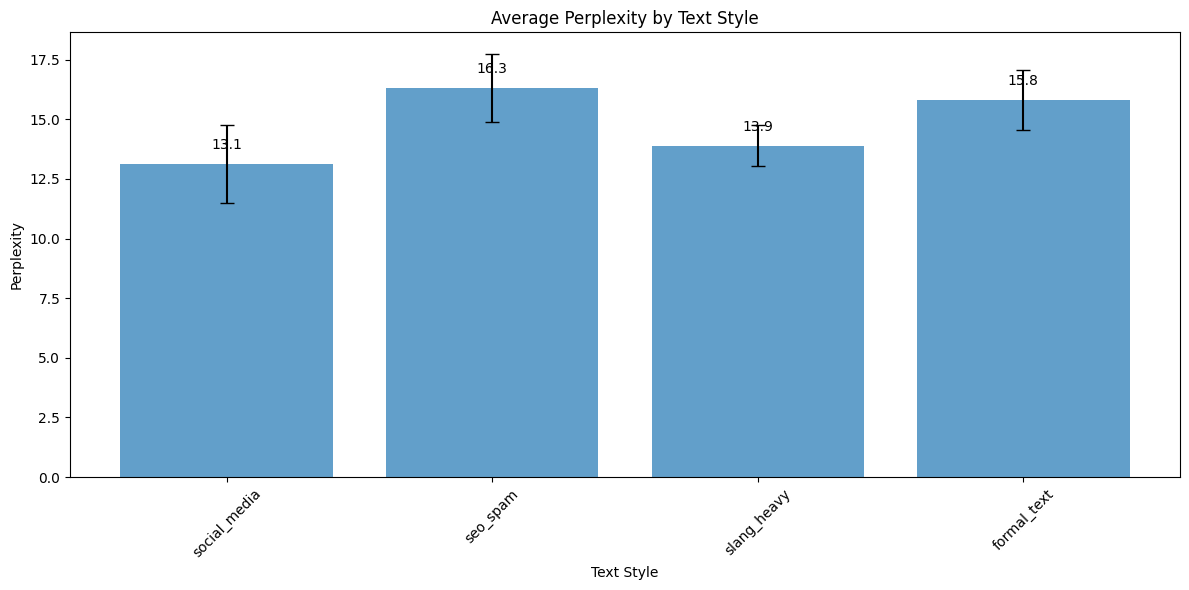


Attempting to train KenLM model...

=== Training KenLM Model ===

Loading C4 realnewslike dataset...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/root/.cache/huggingface/modules/datasets_modules/datasets/c4/584d57ebe81c209b6c7f31727066d2c4b4bba37cb7092cdd83083d5ec11207db/c4.py:53: FutureWarning: Dataset 'c4' is deprecated and will be deleted. Use 'allenai/c4' instead.
  warnings.warn(


Error training model: Loading a dataset cached in a LocalFileSystem is not supported.
Using pre-trained model approach...

=== Evaluating C4 Documents ===

No trained model available. Using simple evaluation...
Loading C4 dataset for evaluation...


/root/.cache/huggingface/modules/datasets_modules/datasets/c4/584d57ebe81c209b6c7f31727066d2c4b4bba37cb7092cdd83083d5ec11207db/c4.py:53: FutureWarning: Dataset 'c4' is deprecated and will be deleted. Use 'allenai/c4' instead.
  warnings.warn(
Old caching folder /root/.cache/huggingface/datasets/c4/en/0.0.0/584d57ebe81c209b6c7f31727066d2c4b4bba37cb7092cdd83083d5ec11207db for dataset c4 exists but no data were found. Removing it. 


Error evaluating documents: [Errno 28] No space left on device

=== Perplexity as Quality Measure Analysis ===

Quality Assessment Examples:

HIGH QUALITY TEXTS:
------------------------------
1. Text: The research demonstrates significant improvements in renewable energy efficiency through advanced photovoltaic technologies.
   Estimated Perplexity: 1.15
   Avg Word Length: 8.69
   Unique Word Ratio: 1.00

2. Text: Economic policy decisions require careful consideration of both short-term impacts and long-term sustainability goals.
   Estimated Perplexity: 1.33
   Avg Word Length: 7.50
   Unique Word Ratio: 1.00

3. Text: Climate change mitigation strategies must integrate technological innovation with policy reform and social adaptation.
   Estimated Perplexity: 1.33
   Avg Word Length: 7.50
   Unique Word Ratio: 1.00


MEDIUM QUALITY TEXTS:
------------------------------
1. Text: The weather today is nice and I think we should go outside to enjoy it.
   Estimated Perplexity: 2.63
  

In [ ]:
def main():
    print("Text Perplexity Analysis with KenLM")
    print("=" * 50)

    # Install requirements
    try:
        install_requirements()
    except Exception as e:
        print(f"Warning: Could not install some requirements: {e}")

    # 1. Analyze different text styles
    style_results = analyze_text_styles()

    # 2. Train KenLM model (optional - requires compilation)
    print("\nAttempting to train KenLM model...")
    trained_model = None
    try:
        download_kenlm()
        trained_model = train_kenlm_model()
    except Exception as e:
        print(f"KenLM training not available: {e}")
        print("Continuing with alternative evaluation...")

    # 3. Evaluate C4 documents
    evaluation_results = evaluate_c4_documents(trained_model)

    # 4. Analyze perplexity as quality measure
    analyze_perplexity_quality()

    print("\n" + "=" * 50)
    print("Analysis complete! Check the generated plots:")
    print("• perplexity_by_style.png - Style comparison")
    print("• perplexity_distribution.png - Document distribution")

if __name__ == "__main__":
    main()